In [3]:
##########Figure 4 GRL - November 2023
#Trend maps predicted
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import esmtools
import dask 

import cmocean
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

In [4]:
data_input = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/MULTIOBS_GLO_BIO_BGC_3D_REP_015_010/Surface/'
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.open_mfdataset(data_input + 'CMEMS_chl_*.nc')
    ds = ds.resample(time="1M").mean()

In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 689, longitude: 1440, time: 288)
Coordinates:
    depth      int16 0
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1998-01-31 1998-02-28 ... 2021-12-31
Data variables:
    chl        (time, latitude, longitude) float32 dask.array<chunksize=(1, 689, 1440), meta=np.ndarray>

In [8]:
cm = cmocean.cm.balance
vm = 20
unit = '%.year$^{-1}$'
proj=ccrs.Robinson(central_longitude = 210)
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
subplot_kw = {'projection': proj} 

/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


CCI


/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


VIR


/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


GSM


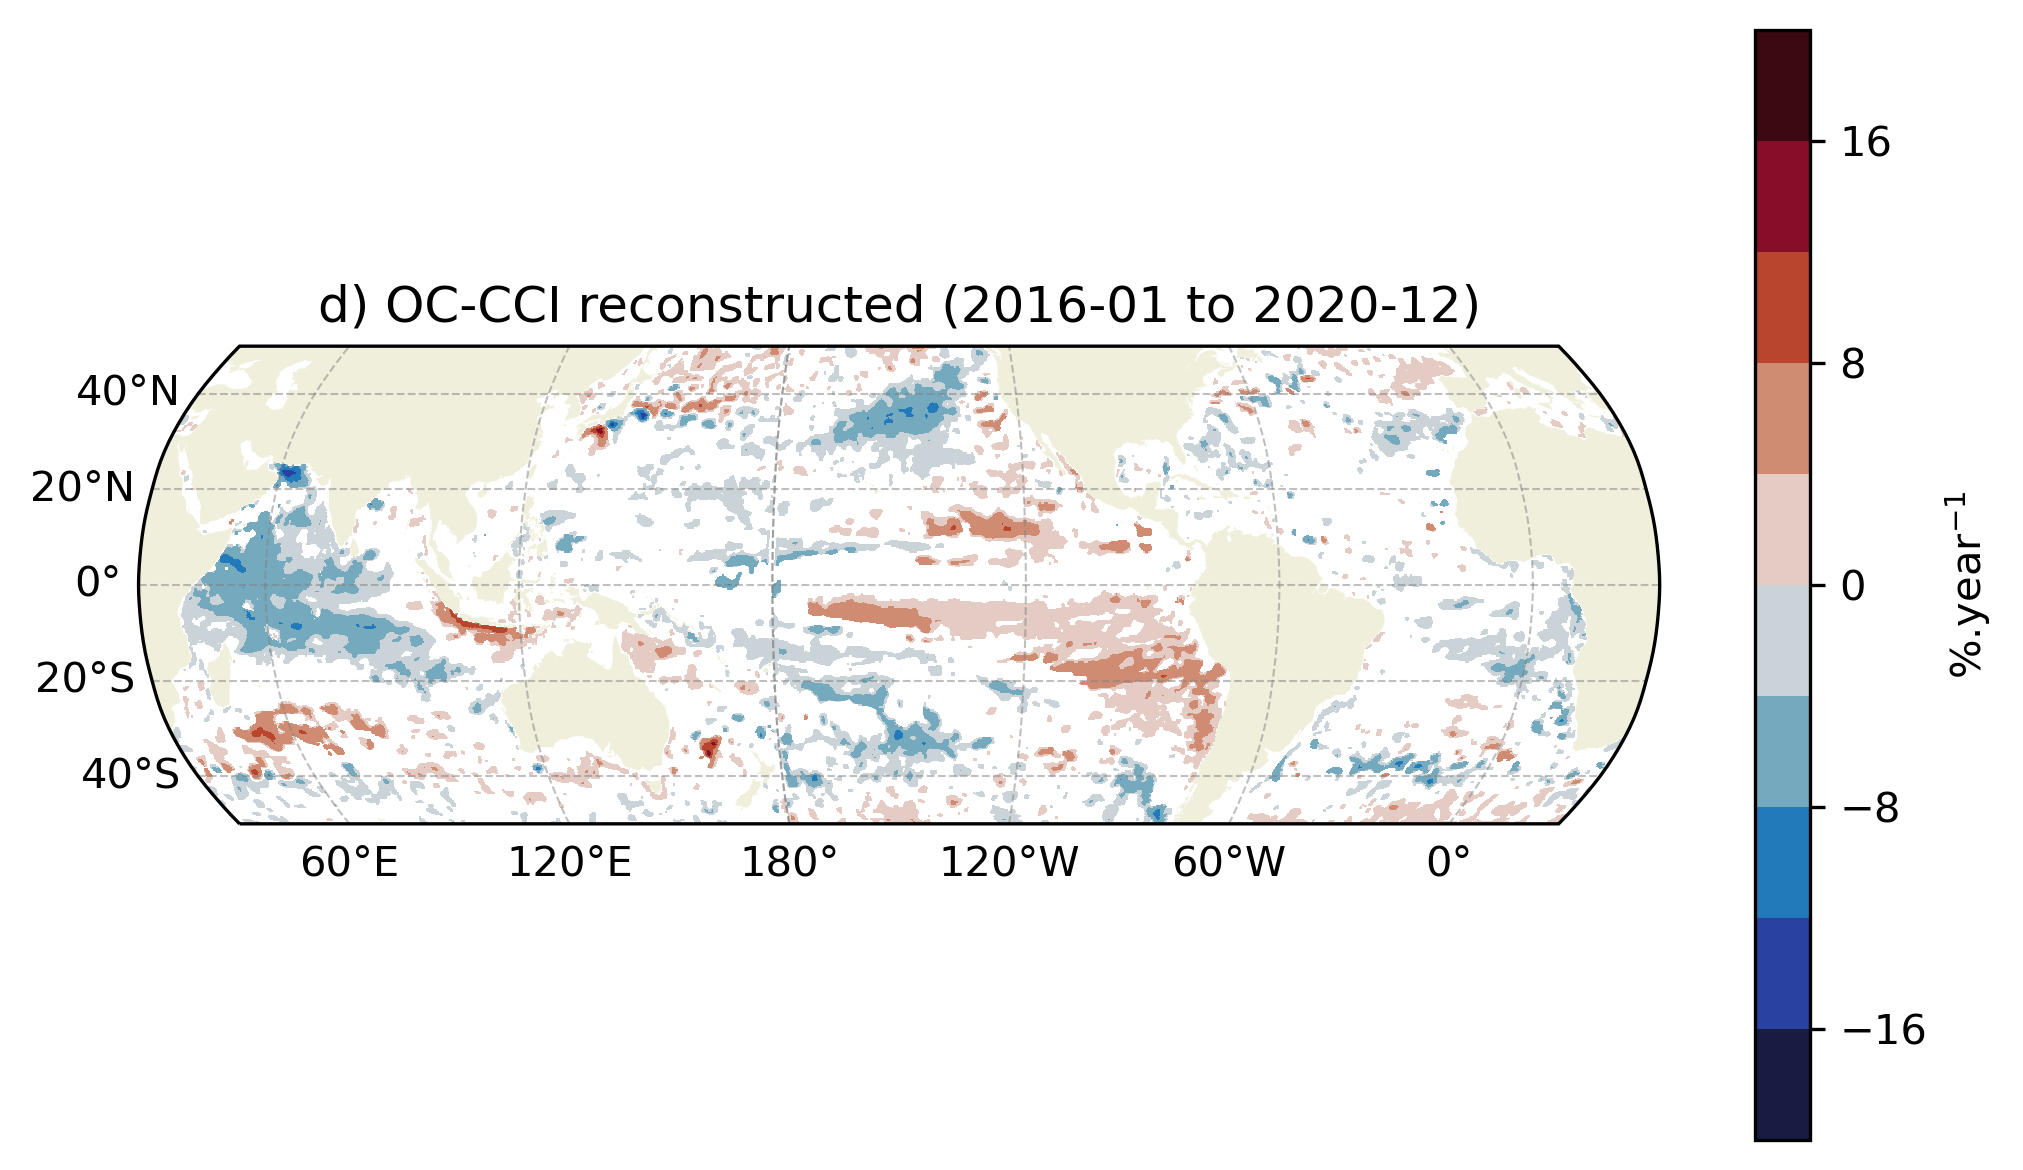

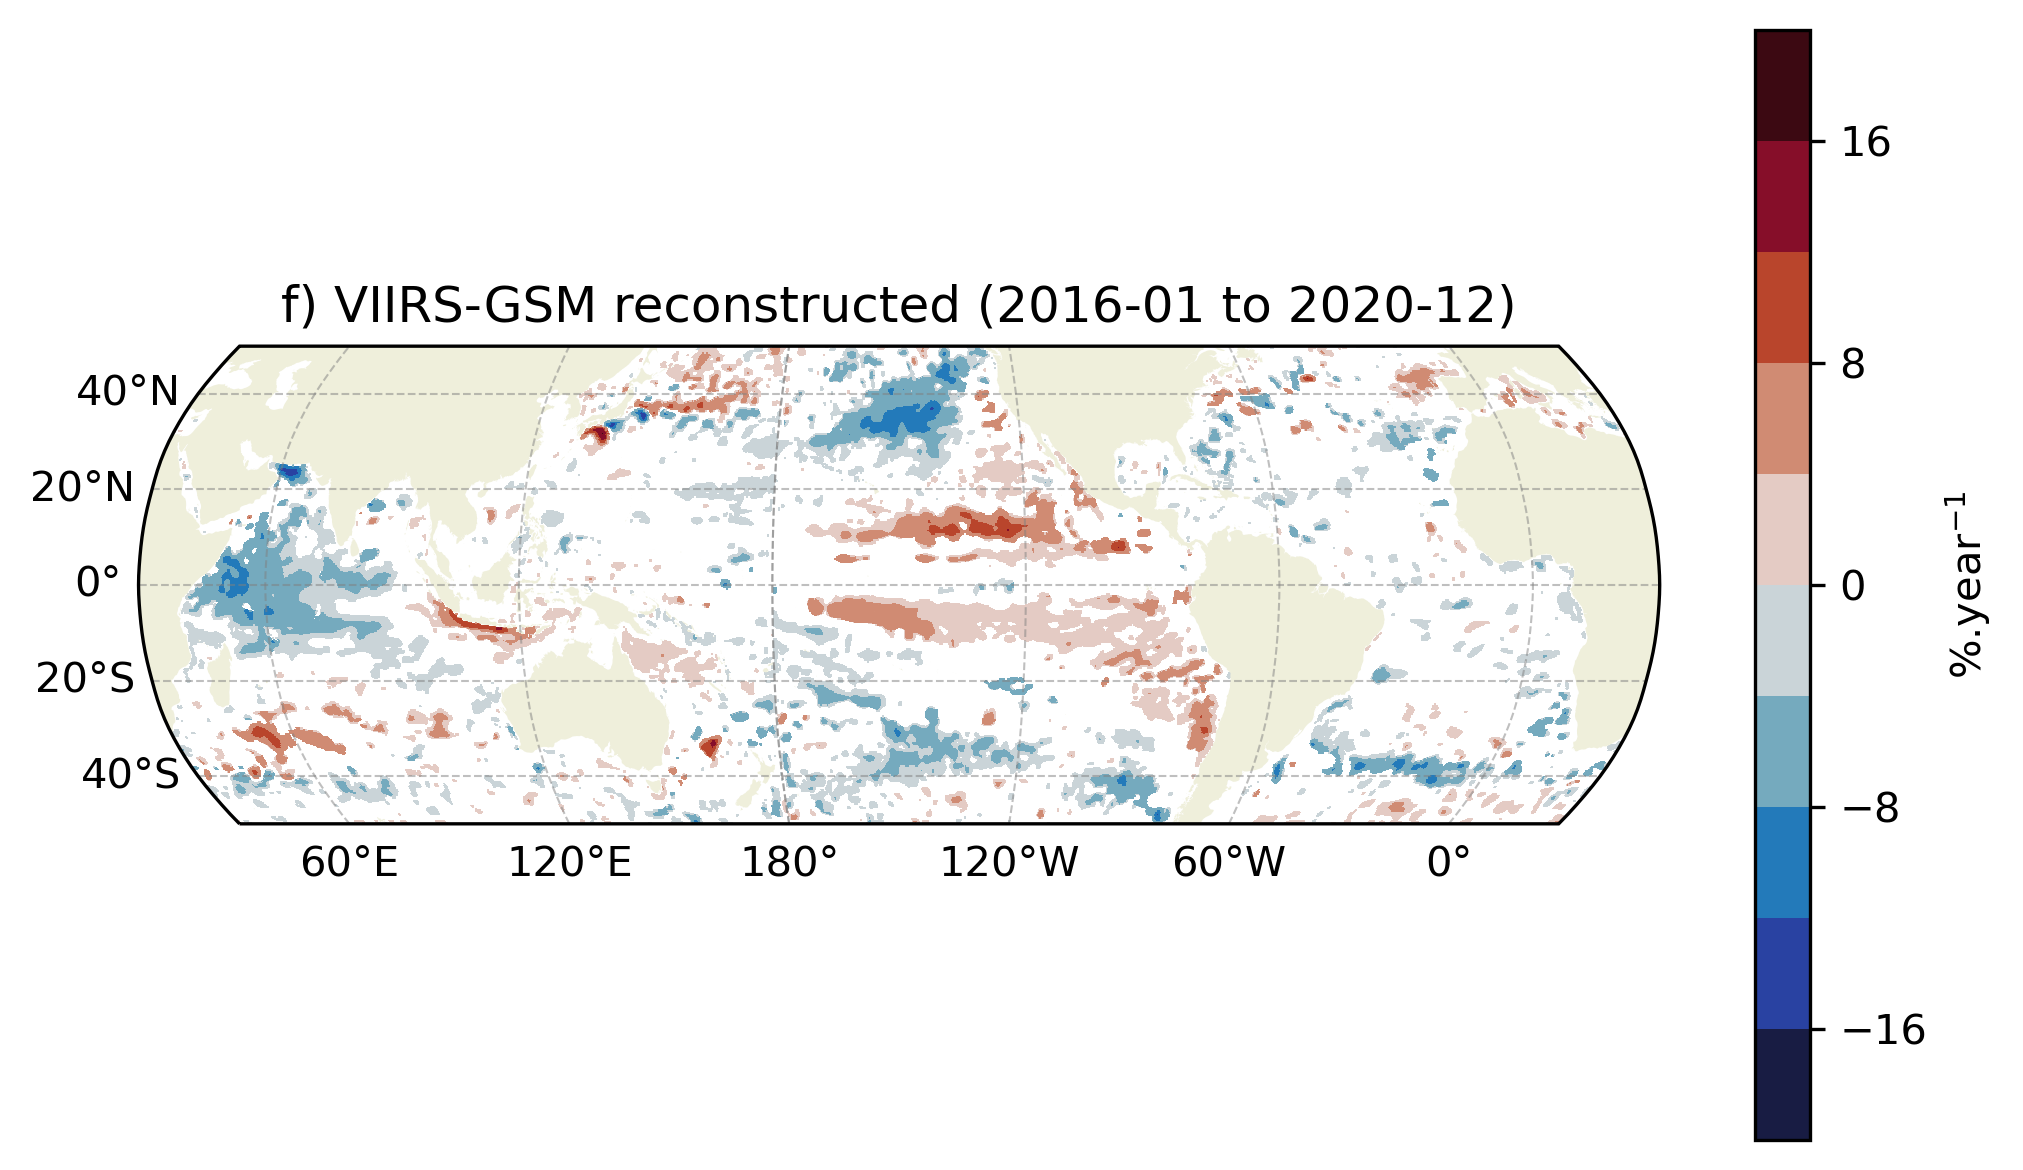

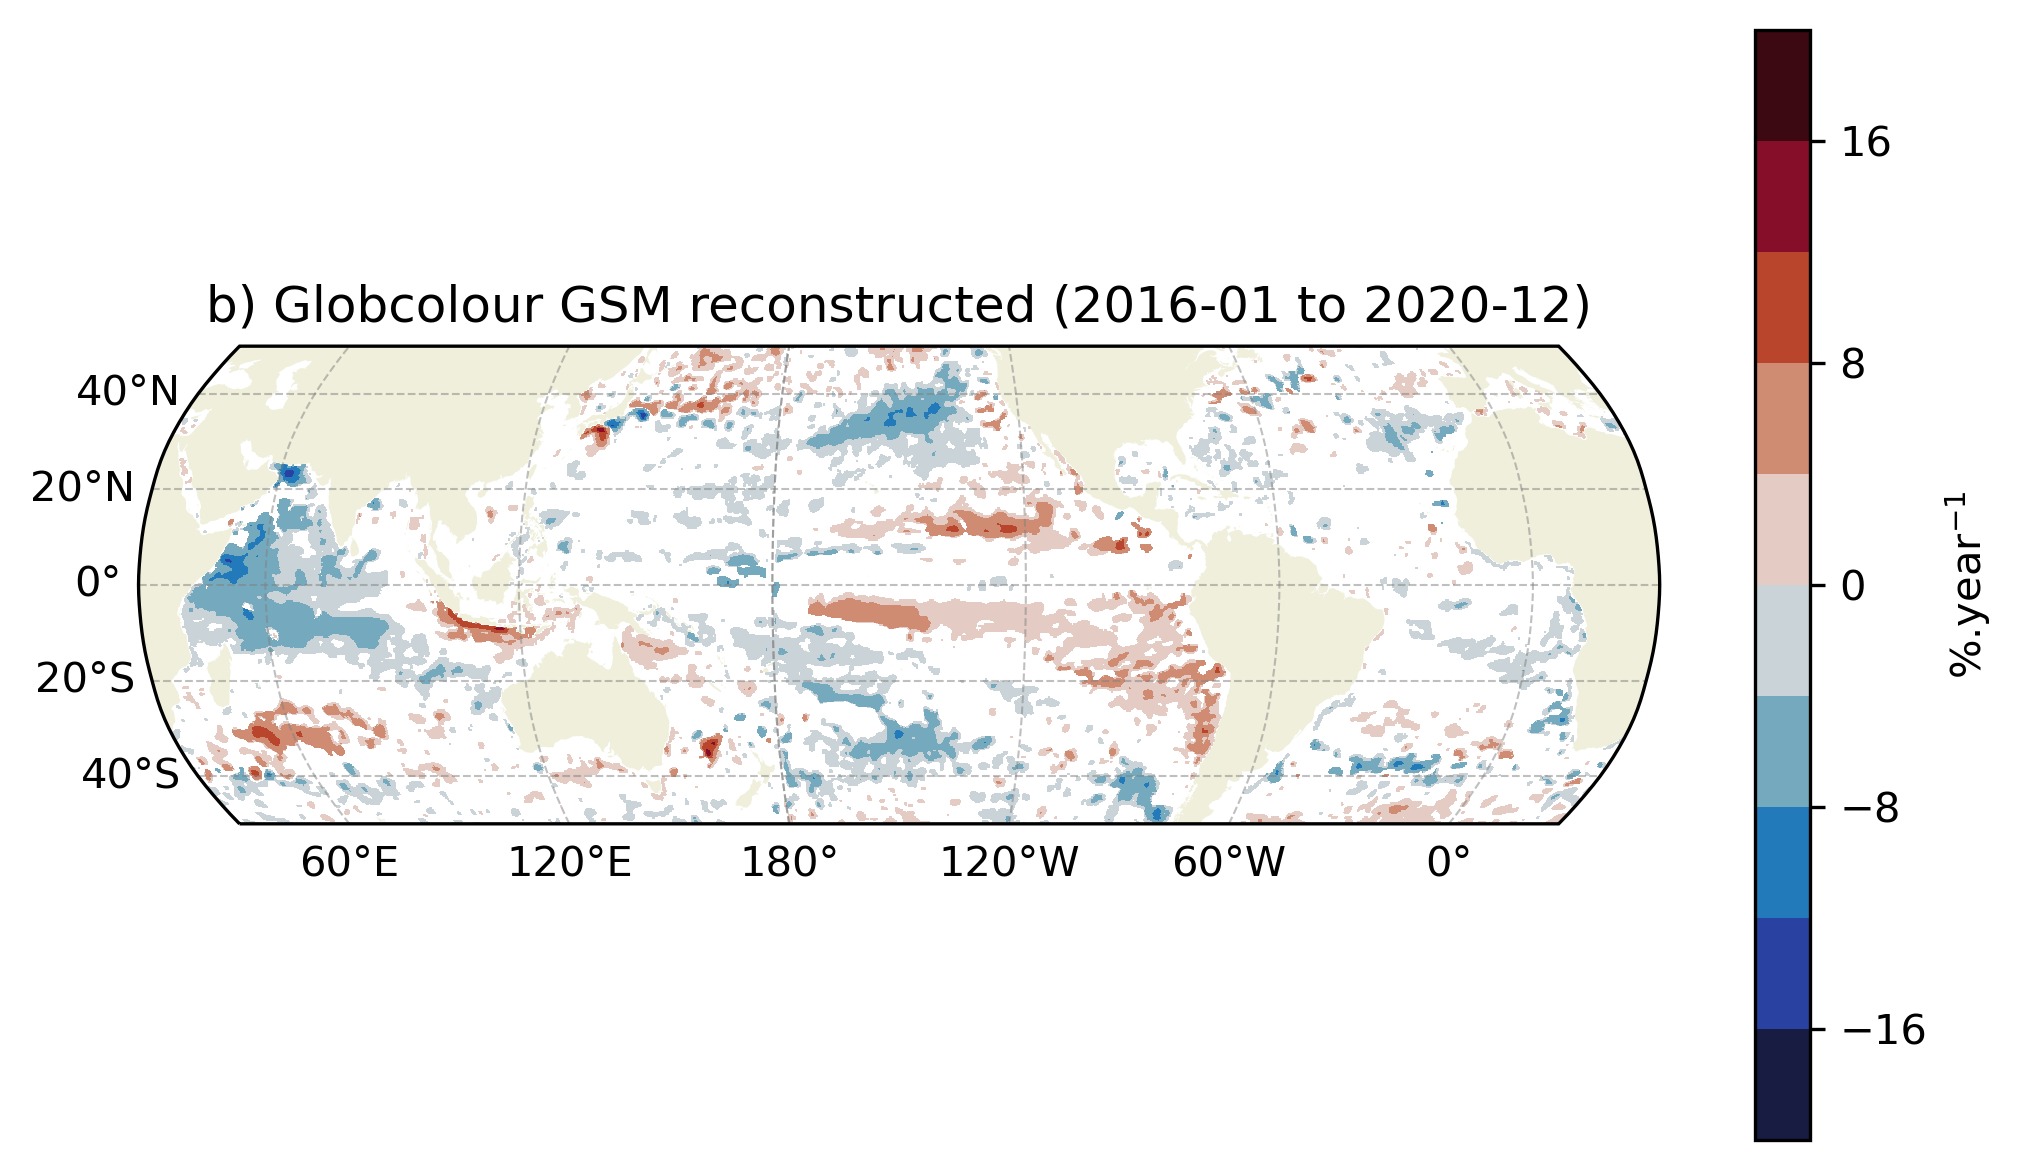

In [10]:
#name = "CCI"
name = "GSM"
#name = "VIR"
#name = "GCMEMS"
namelist = ['CCI','VIR','GSM']
letter = ['d) OC-CCI','f) VIIRS-GSM','b) Globcolour GSM']
i = 0
for name in namelist:
    ds = xr.open_dataset('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/OUTPUT/Model_GRL/'+name+'_ensemble_mean.nc')
    d1 = '2016-01'
    d2 = '2020-12'
    ds = ds.sel(time = slice(d1,d2))

    #trend on deseasonalised or raw
    ds = ds.assign(variables={"chl_log": (('time','latitude','longitude'), np.log(ds.chloro_pred.data))})
    ds = ds.drop(['chloro_pred']).load()
    ds_season = ds.groupby('time.month').mean(dim='time').chl_log
    ds_monthly = ds.groupby('time.month')
    ds = ds.assign(variables={"chl_deseason": (('time','latitude','longitude'), (ds_monthly - ds_monthly.mean(dim='time')).chl_log.data)})
    ds = ds.drop(['chl_log'])
    ds_lr = esmtools.stats.linregress(ds, dim='time', nan_policy='omit')        

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4), dpi=300, subplot_kw=subplot_kw, tight_layout=True)
    ds_sig = ds_lr.where(ds_lr.sel(parameter='pvalue')<=0.05)
    (ds_sig.chl_deseason.sel(parameter='slope')*1200).plot(vmin = -vm,vmax = vm,cmap = cm,transform=ccrs.PlateCarree(),ax = ax
                                                ,cbar_kwargs=dict(label=unit),levels =11)
    ax.set_title(letter[i] + " reconstructed (" + str(d1) + ' to ' + str(d2) + ')')
    ax.grid(True)
    ax.add_feature(land_feature) #, edgecolor='black')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig('Figure_GRL/Fig4_'+name+d1+d2+'_pred_deseason.png', bbox_inches='tight')
    i+=1
    print(name)